<a href="https://colab.research.google.com/github/robd123/IndepResearch/blob/master/BugClassificationBERT_TypeOnly_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
model_name = "t5-small"
token_len = 512
model_prefix = f"{model_name}-{token_len}"

In [ ]:
pip install sentencepiece

     |████████████████████████████████| 1.2 MB 6.2 MB/s 


In [ ]:
#pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl


In [ ]:
#pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchtext==0.10.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

In [ ]:
pip install pytorch-lightning

     |████████████████████████████████| 527 kB 8.3 MB/s 
     |████████████████████████████████| 596 kB 43.3 MB/s 
     |████████████████████████████████| 398 kB 51.0 MB/s 
     |████████████████████████████████| 952 kB 39.2 MB/s 
     |████████████████████████████████| 829 kB 35.0 MB/s 
     |████████████████████████████████| 134 kB 18.9 MB/s 
     |████████████████████████████████| 1.1 MB 19.1 MB/s 
     |████████████████████████████████| 271 kB 43.3 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 144 kB 36.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=8028d40f902954853f8a4bb10be62f59e9519978ae08d6e8debf697afbd2b715
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

In [ ]:
pip install nlp

     |████████████████████████████████| 1.7 MB 8.3 MB/s 
     |████████████████████████████████| 212 kB 50.1 MB/s 


In [ ]:
pip install transformers

     |████████████████████████████████| 3.8 MB 8.3 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 895 kB 39.9 MB/s 
     |████████████████████████████████| 6.5 MB 32.5 MB/s 


In [ ]:
pip install wandb

     |████████████████████████████████| 1.7 MB 8.4 MB/s 
     |████████████████████████████████| 181 kB 43.8 MB/s 
     |████████████████████████████████| 144 kB 51.3 MB/s 
     |████████████████████████████████| 63 kB 856 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=4f23389344a2f6930577d41edb09219bde2793a176599bd7800ee9eced896421
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
from pytorch_lightning.loggers.wandb import WandbLogger
import os
from pathlib import Path
from string import punctuation

os.environ["WANDB_API_KEY"] = '33461c97826e5a650bb71bec8b3e694e7c6ee9f6'
wandb_logger = WandbLogger(project='bugclassification-t5small')

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import string
import pandas as pd
# pd.set_option('display.max_colwidth', -1)
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from nlp import load_metric

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup,
    BertForSequenceClassification,
    BertTokenizer,
)
import random
import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import auth
auth.authenticate_user()

!gcloud config set project eternal-bruin-340122

!gsutil cp gs://robd_indep_research/linux_bugs_usage_ready.csv /tmp/dataset.csv

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey

Copying gs://robd_indep_research/linux_bugs_usage_ready.csv...
- [1 files][ 40.8 MiB/ 40.8 MiB]                                                
Operation completed over 1 objects/40.8 MiB.                                     


Text Processing Functions
From https://github.com/Forethought-Technologies/ieee-dsmp-2018-paper/blob/master/text_processing.py

In [ ]:
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

def strip_punctuations(data, column_name='text'):
  '''
  Strips punctuations from the end of each token.
  This uses suggestion from https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate
  to accomplish this really fast.
  '''
  translator = str.maketrans('', '', string.punctuation)
  data['text'] = data['text'].map(lambda s : str(s).translate(translator))
  return data

def stemm_text(data, stemmer_choice='Lancaster'):
  '''
  Stemm the 'text' column of data - this simplifies the words so
  that different forms of the same word end up being the same.
  '''
  if stemmer_choice == 'Lancaster':
    stemmer = LancasterStemmer()
  elif stemmer_choice == 'Snowball':
    stemmer = SnowballStemmer('english')
  elif stemmer_choice == 'Porter':
    stemmer = PorterStemmer()
  else:
    raise Exception('Illegal stemmer_choice argument')
  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: stemmer.stem(w), s.split())))
  return data

def remove_long_words(data, maxlen=16):
  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: w if len(w) < maxlen else ' ', s.split())))
  return data

def remove_short_words(data, minlen=4):
  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: w if len(w) >= minlen else ' ', s.split())))
  return data

def remove_linux_garbage(data):
  '''
  Linux data contains lots of garbage, e.g. memory addresses - 0000f800
  '''
  def is_garbage(w):
    return len(w) >= 7 and sum(c.isdigit() for c in w) >= 2

  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: w if not is_garbage(w) else ' ', s.split())))
  return data

def cast_to_lowercase(data):
  data['text'] = data['text'].map(lambda s : s.lower())
  return data

def remove_stopwords(data):
  stop_words = stopwords.words('english')
  translator = str.maketrans('', '', string.punctuation)
  stop_words = set([w.translate(translator) for w in stop_words]) # Apostrophes were removed already

  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: w if w not in stop_words else ' ', s.split())))
  return data

def remove_rare_words(data, min_count=3):
  wc = {} # WordCount
  def proc_word(s):
    for w in set(s.split()):
      if w in wc:
        wc[w] += 1
      else:
        wc[w] = 1

  for index, row in data.iterrows():
    proc_word(row['text'])

  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: w if wc[w] >= min_count else ' ', s.split())))
  return data

In [ ]:
data = pd.read_csv('/tmp/dataset.csv', sep='\t')

In [ ]:
data.head()

,title,message,importance,product,component
0,oops when using ide-cd with 2.5.45 and cdrecord,Please enter Exact Kernel version:2.5.45 Distr...,P2 normal,IO/Storage,IDE
1,NUMA-Q hangs during TSC initialization on boot.,Exact Kernel version: 2.5.46 Distribution: deb...,P2 normal,Platform Specific/Hardware,i386
2,Enabling shared pagetables causes KDE to wierd...,Exact Kernel version: 2.5.46-mm1 Distribution:...,P2 normal,Memory Management,Other
3,Dcache spirals out of control on 2.5.43-mm2,Exact Kernel version: 2.5.43-mm2 Distribution:...,P2 blocking,IO/Storage,Other
4,64GB highmem BUG(),Exact Kernel version: 2.5.40 Hardware Environm...,P2 normal,Memory Management,Other


In [ ]:
  data['text'] = data['title'] + ' ' + data['message']
  data = data.drop(['title'], axis=1)
  data = data.drop(['message'], axis=1)
  data.head()

,importance,product,component,text
0,P2 normal,IO/Storage,IDE,oops when using ide-cd with 2.5.45 and cdrecor...
1,P2 normal,Platform Specific/Hardware,i386,NUMA-Q hangs during TSC initialization on boot...
2,P2 normal,Memory Management,Other,Enabling shared pagetables causes KDE to wierd...
3,P2 blocking,IO/Storage,Other,Dcache spirals out of control on 2.5.43-mm2 Ex...
4,P2 normal,Memory Management,Other,64GB highmem BUG() Exact Kernel version: 2.5.4...


In [ ]:
data['prio'] = [a[:2] for a in data['importance']]
data['type'] = [a[3:] for a in data['importance']]

In [ ]:
data.drop(data[data['type'] == 'blocking'].index, inplace = True)
data.drop(data[data['type'] == 'enhancement'].index, inplace = True)
data.drop(data[data['type'] == 'empty'].index, inplace = True)

In [ ]:
data["type_num"] = [0 if a == 'low' else 1 if a == 'normal' else 2 for a in data["type"]]

In [ ]:
data.head()

,importance,product,component,text,prio,type,type_num
0,P2 normal,IO/Storage,IDE,oops when using ide-cd with 2.5.45 and cdrecor...,P2,normal,1
1,P2 normal,Platform Specific/Hardware,i386,NUMA-Q hangs during TSC initialization on boot...,P2,normal,1
2,P2 normal,Memory Management,Other,Enabling shared pagetables causes KDE to wierd...,P2,normal,1
4,P2 normal,Memory Management,Other,64GB highmem BUG() Exact Kernel version: 2.5.4...,P2,normal,1
5,P2 normal,Memory Management,Slab Allocator,2.5.41 oops in kmem_cache_create Exact Kernel ...,P2,normal,1


In [ ]:
data.type_num.describe()

count    15373.000000
mean         1.112860
std          0.474238
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: type_num, dtype: float64

In [ ]:
nltk.download('stopwords')
data = strip_punctuations(data)
data = remove_linux_garbage(data)
data = cast_to_lowercase(data)
data = remove_stopwords(data)
data = remove_rare_words(data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data.head()

,importance,product,component,text,prio,type,type_num
0,P2 normal,IO/Storage,IDE,oops using idecd 2545 cdrecord please enter ex...,P2,normal,1
1,P2 normal,Platform Specific/Hardware,i386,numaq hangs tsc initialization boot exact kern...,P2,normal,1
2,P2 normal,Memory Management,Other,enabling shared pagetables causes kde wierd ex...,P2,normal,1
4,P2 normal,Memory Management,Other,64gb highmem bug exact kernel version 2540 har...,P2,normal,1
5,P2 normal,Memory Management,Slab Allocator,2541 oops kmemcachecreate exact kernel version...,P2,normal,1


In [ ]:
from sklearn.model_selection import train_test_split

X = data['text']
Y = data['type_num']

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11, stratify=Y)

In [ ]:
train_val_df = X_train_val.to_frame()
train_val_df['target'] = Y_train_val

In [ ]:
test_df = X_test.to_frame()
test_df['target'] = Y_test

In [ ]:
data.shape

(15373, 7)

In [ ]:
import numpy as np
import pandas as pd


class BugData(Dataset):
    def __init__(self, df, tokenizer, type_path, num_samples, input_length=4096, output_length=4096, print_text=False):         
        ## Shuffle data set
        self.dataset = []
        val_size = int(0.2 * df.shape[0])

        inps = df["text"].values.tolist()
        lbls = df["target"].values.tolist()

        for i, inp in enumerate(inps):
            inp = inp.replace(":", "")
            lbl = str(lbls[i])
            self.dataset.append({"inp": inp, "lbl": lbl})

        
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
        
  
    def __len__(self):
        return len(self.dataset)

    def convert_to_features(self, example_batch):
        
        input_ = example_batch['inp']      
        input_ = input_.strip()      
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        return source
  
    def __getitem__(self, index):
        source = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        src_mask = source["attention_mask"].squeeze()
        tk_type_ids = source["token_type_ids"].squeeze()

        return {"input_ids": source_ids, "attention_mask": src_mask, "label": torch.tensor(int(self.dataset[index]['lbl'])).long(), "token_type_ids": tk_type_ids}


    def get_unconverted_test_data(self):
      data = BugData(df = df, tokenizer=tokenizer, type_path="test", num_samples=-1, input_length=args.max_input_length, 
                        output_length=args.max_output_length)
      return self.dataset


def get_dataset(tokenizer, type_path, num_samples, args):
      if type_path == 'train':
          return BugData(train_df, tokenizer=tokenizer, type_path=type_path, num_samples=num_samples, input_length=args.max_input_length, 
              output_length=args.max_output_length)
      elif type_path == 'validation':
            return BugData(val_df, tokenizer=tokenizer, type_path=type_path, num_samples=num_samples, input_length=args.max_input_length, 
              output_length=args.max_output_length)
      elif type_path == 'test':
            return BugData(test_df, tokenizer=tokenizer, type_path=type_path, num_samples=num_samples, input_length=args.max_input_length, 
              output_length=args.max_output_length)

In [ ]:
from collections import OrderedDict

fold_number = 0 #Used to track the fold number for WandB logging

class BERTBugClassifier(pl.LightningModule):
    def __init__(self, hparams):
        super(BERTBugClassifier, self).__init__()
        self.save_hyperparameters(hparams)        
        self.model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
        self.output_dir = Path(self.hparams.output_dir)
        self.step_count = 0

    def ign_forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        return self.model(
                input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                labels=labels
            )
      
    def train_dataloader(self):   
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=-1, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=1)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler

        return dataloader

    def val_dataloader(self):
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=-1, args=self.hparams)
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=1)
    
    def test_dataloader(self):
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=-1, args=self.hparams)
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=1)

    def training_step(self, batch, batch_idx):
        labels = batch["label"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        token_type_ids = batch["token_type_ids"]

        out = self.model(
                input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attention_mask,
                labels=labels
                )
        loss = out[0]
        tqdm_dict = {"train_loss": loss}
        
        self.log("train/loss_fold_" + str(fold_number), loss, on_step=True, on_epoch=True)
        output = OrderedDict({
            "loss": loss,
            "progress_bar": tqdm_dict,
            "log": tqdm_dict
            })

        return output

    def validation_step(self, batch, batch_idx):
        labels = batch["label"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        token_type_ids = batch["token_type_ids"]

        out = self.model(
                input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attention_mask,
                labels=labels
                )
        loss = out[0]

        self.log("val/loss_fold_" + str(fold_number), loss, on_step=True, on_epoch=True)
        output = OrderedDict({
            "val_loss": loss,
            "batch_size": len(labels)
            })
        return output

    def validation_end(self, outputs):
        val_acc = sum([out["correct_count"] for out in outputs]).float() / sum(out["batch_size"] for out in outputs)
        val_loss = sum([out["val_loss"] for out in outputs]) / len(outputs)
        tqdm_dict = {
                "val_loss": val_loss,
                "val_acc": val_acc,
                }
        result = {"progress_bar": tqdm_dict, "log": tqdm_dict, "val_loss": val_loss}
        return result

    def configure_optimizers(self):

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]


In [ ]:
args_dict = dict(
    output_dir="", # path to save the checkpoints
    model_name_or_path=model_name,
    tokenizer_name_or_path=model_name,
    max_input_length=token_len,
    max_output_length=token_len,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=2e-5,
    weight_decay=0.1,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=1,
    eval_batch_size=1,
    num_train_epochs=10,
    n_gpu=1,
    gradient_accumulation_steps=8,
    val_check_interval = 0.5, 
    n_val=-1,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)


args_dict.update({'output_dir': "./" + model_prefix + "_final", 'num_train_epochs':5,
             'train_batch_size': 8, 'eval_batch_size': 8, 'resume_from_checkpoint' : 't5-small-512t5-small-512_ckpt_epoch_29.ckpt'})
args = argparse.Namespace(**args_dict)



In [ ]:
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    precision= 16 if args.fp_16 else 32,
    amp_backend='apex',
    #tpu_cores=8,
    gpus=1,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    val_check_interval=args.val_check_interval,
    logger=wandb_logger,
    max_epochs=4,
    # progress_bar_refresh_rate=0
)

model = BERTBugClassifier(args)
#trainer = pl.Trainer(**train_params)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
X_train_val = train_val_df['text']
Y_train_val = train_val_df['target']
skf.get_n_splits(X_train_val, Y_train_val)
for train_index, test_index in skf.split(X_train_val, Y_train_val):
  X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
  Y_train, Y_val = Y_train_val.iloc[train_index], Y_train_val.iloc[test_index]
  train_df = X_train.to_frame()
  train_df['target'] = Y_train
  val_df = X_val.to_frame()
  val_df['target'] = Y_val
  trainer = pl.Trainer(**train_params)
  trainer.fit(model)
  fold_number = fold_number + 1

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
wandb: Currently logged in as: robd123 (use `wandb login --relogin` to force relogin)



  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M 
--------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.938   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M 
--------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.938   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/bugclassification-t5small/1mssrxq5/checkpoints exists and i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M 
--------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.938   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M 
--------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.938   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M 
--------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.938   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
#trainer.fit(model)

In [ ]:
torch.save(model.state_dict(), '/content/sample_data/bc_type_bert_model_cv.pt')

In [ ]:
!gsutil cp /content/sample_data/bc_type_bert_model_cv.pt gs://robd_indep_research/Results

Copying file:///content/sample_data/bc_type_bert_model_cv.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][417.7 MiB/417.7 MiB]                                                
Operation completed over 1 objects/417.7 MiB.                                    


In [ ]:
!gsutil cp gs://robd_indep_research/Results/bc_type_bert_model_cv.pt /content/sample_data/ 

Copying gs://robd_indep_research/Results/bc_type_2_bert_model_2.pt...
- [1 files][417.7 MiB/417.7 MiB]                                                
Operation completed over 1 objects/417.7 MiB.                                    


In [ ]:
model = BERTBugClassifier(args)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.load_state_dict(torch.load('/content/sample_data/bc_type_bert_model_cv.pt'))

<All keys matched successfully>

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True, return_tensors="pt")
df = test_df.copy()
dataset = BugData(df, tokenizer, 'test', None, token_len, token_len, True).get_unconverted_test_data()
data_len = len(dataset)
print(data_len)

3075


In [ ]:
model.to('cuda')
preds = []
targets = []
num = 0;
labels = torch.tensor([[0, 1, 2]], dtype=torch.float)
for record in dataset:
  tk = tokenizer(record["inp"],  return_tensors="pt")
  if (len(tk["input_ids"][0]) <= 512):
    targets.append(int(record["lbl"]))
    tk = tk.to('cuda')
    logits = model.model(**tk).logits
    pred = torch.argmax(logits, dim=1)
    preds.append(int(pred[0].cpu()))

Token indices sequence length is longer than the specified maximum sequence length for this model (1448 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
accuracy_score(targets, preds)

0.7708955223880597

In [ ]:
confusion_matrix(targets, preds)

array([[  17,  153,    4],
       [   7, 1992,   67],
       [   3,  380,   57]])

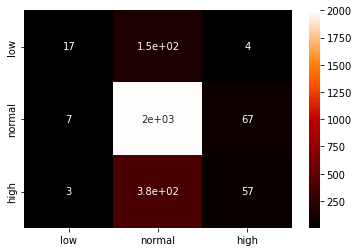

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(targets, preds)
labels = ['low', 'normal', 'high']
sns.heatmap(cm, cmap='gist_heat', annot=True, vmax=2000, xticklabels=labels, yticklabels=labels)